In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/glouppe/anaconda3/envs/dats0001/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv(f"data/penguins.csv")

In [3]:
data = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "species"]].dropna().values
species = data[:, -1]
species = pd.Series(species).astype("category").cat.codes
data = data[:, :-1].astype(np.float32)


Estimated B:
 [[ 3.24932654e+00 -2.00767630e+00]
 [-9.32022333e-01  5.88613519e-01]
 [ 1.22514701e+01 -6.16177069e+00]
 [ 8.01948800e+02  1.02952890e-01]]
Estimated mu:
 [  43.921932   17.15117   200.9152   4201.7544  ]
Estimated sigma^2:
 9.18956716162383


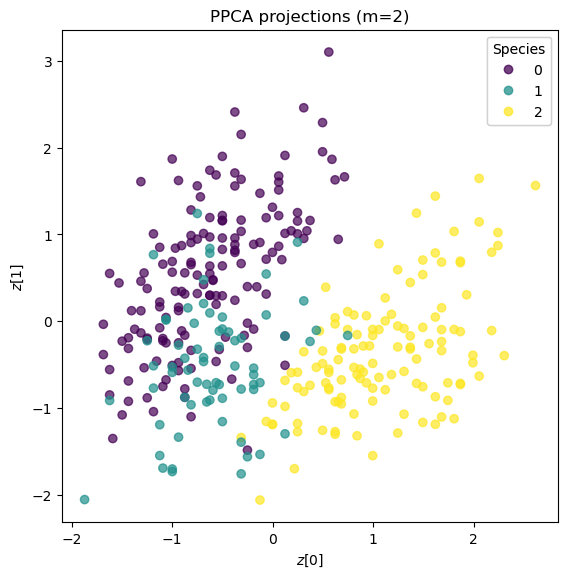

In [5]:
# Probabilistic PCA
def fit_ppca(X, m):
    N, d = X.shape
    mu = np.mean(X, axis=0)
    X_centered = X - mu

    S = np.cov(X_centered, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eigh(S)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    sigma2 = np.mean(eigenvalues[m:])

    Lambda_m = np.diag(eigenvalues[:m] - sigma2)
    U_m = eigenvectors[:, :m]
    B = U_m @ np.sqrt(Lambda_m)  

    return B, mu, sigma2

B, mu, sigma2 = fit_ppca(data, m=2)
print("Estimated B:\n", B)
print("Estimated mu:\n", mu)
print("Estimated sigma^2:\n", sigma2)

# Posterior distribution of latent variables
def project_ppca(X, B, mu, sigma2):
    X_centered = X - mu
    Sigma = B @ B.T + sigma2 * np.eye(B.shape[0])
    Sigma_inv = np.linalg.inv(Sigma)
    m = B.T @ Sigma_inv @ X_centered.T
    C = np.eye(B.shape[1]) - B.T @ Sigma_inv @ B
    return m.T, C

Z, C = project_ppca(data, B, mu, sigma2)

# Plotting posterior means
fig = plt.figure(figsize=(6.4, 6.4), dpi=100)
ax = plt.axes()

scatter = ax.scatter(Z[:, 0], Z[:, 1], c=species, cmap='viridis', alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Species")
ax.add_artist(legend1)
ax.set_title("PPCA projections (m=2)")
ax.set_xlabel(r"$z[0]$")
ax.set_ylabel(r"$z[1]$")

plt.savefig(f"ppca_projections.png")
plt.show()